In [1]:
import datasets
import lightning as pl
import matplotlib.pyplot as plt
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor, DetrImageProcessor 
from transformers import DetrForObjectDetection, AutoModelForObjectDetection


/home/datsplit/wearables_detection_airport_security/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-12 15:05:12.100240: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 15:05:12.131803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 15:05:13.186221: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Wa

In [2]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

import random
def xyxy_to_xcycwh(box):
    """
    Boxes in images may have the format (x1, y1, x2, y2) and we may need the format (center of x, center of y, width, height).
    :param box: Tensor-like box with format (x1, y1, x2, y2)
    :return: Tensor-like box with format (center of x, center of y, width, height)
    """
    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):
    """
    Boxes in images may have the format (center of x, center of y, width, height) and we may need the format (x1, y1, x2, y2).
    :param box: Tensor-like box with format (center of x, center of y, width, height)
    :return: Tensor-like box with format (x1, y1, x2, y2)
    """
    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [3]:
COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']

def rescale_bboxes(out_bbox, size, down=True):
    """
    Boxes information contains values between 0 and 1 instead of values in pixels. This is made in order to make the boxes independant from the size of the image. But we may need to re-escale the box.
    """
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, boxes, class_labels):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()

In [13]:
# 95% Percent of the dataset will be used for training
train_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=0, to=95, unit="%", rounding="pct1_dropremainder"))
# 5% of the dataset will be used for validation
val_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=95, to=100, unit="%", rounding="pct1_dropremainder"))

In [6]:
cats = train_dataset.features['objects'].feature['category']
cats

def idx_to_text(indexes):
    """
    Converts an index into a category label.
    :param indexes: List of indexes
    :return: List of category labels
    """
    labels = []
    for i in indexes:
        labels.append(cats.names[i])
    return labels

NameError: name 'train_dataset' is not defined

Plotting random item 21140


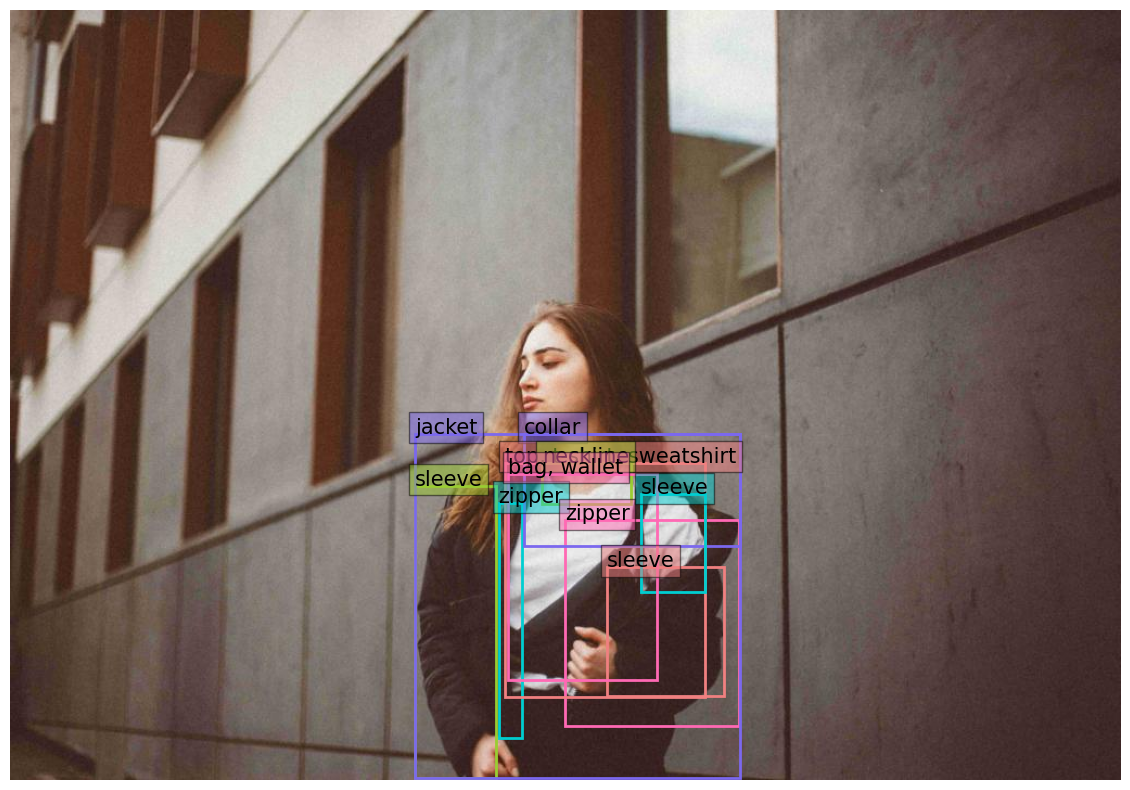

In [15]:
random_i = random.randint(0, train_dataset.num_rows)
print(f"Plotting random item {random_i}")
random_item = train_dataset[random_i]
plot_results(random_item['image'], random_item['objects']['bbox'], idx_to_text(random_item['objects']['category']))

In [4]:
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-base", size=816, longest_edge=864)

/home/datsplit/wearables_detection_airport_security/.venv/lib/python3.12/site-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [5]:
def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [18]:
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)

In [6]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [20]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 43320
Number of validation examples: 2280


In [21]:
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE, num_workers=27)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE, num_workers=27)

In [22]:

class Detr(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-base",
                                                                  num_labels=cats.num_classes, ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [23]:
model = Detr(lr=2.5e-5, weight_decay=1e-4)


Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-base and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
trainer = Trainer(max_epochs=2, accelerator="gpu", devices=1)
torch.set_float32_matmul_precision('medium')

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params | Mode
---------------------------------------------------------
0 | model | YolosForObjectDetection | 127 M  | eval
---------------------------------------------------------
127 M     Trainable params
0         Non-trainable params
127 M     Total params
511.055   Total estimated model params size (MB)
0         Modules in train mode
237       Modules in eval mode


Epoch 1: 100%|██████████| 43320/43320 [5:00:24<00:00,  2.40it/s, v_num=7]     

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 43320/43320 [5:00:28<00:00,  2.40it/s, v_num=7]


In [26]:
model.model.push_to_hub("yolos-base-fashionpedia")


model.safetensors: 100%|██████████| 511M/511M [00:49<00:00, 10.3MB/s]


CommitInfo(commit_url='https://huggingface.co/DatSplit/yolos-base-fashionpedia/commit/19a3452dfa0b0ec150137dd409aa947c6369dac3', commit_message='Upload YolosForObjectDetection', commit_description='', oid='19a3452dfa0b0ec150137dd409aa947c6369dac3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/DatSplit/yolos-base-fashionpedia', endpoint='https://huggingface.co', repo_type='model', repo_id='DatSplit/yolos-base-fashionpedia'), pr_revision=None, pr_num=None)

In [7]:
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

In [8]:
IMAGE_PATH = "test.jpg"
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']
def idx_to_text(i):
    return cats[i]
# Random colors used for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10,
                bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.show()
    plt.savefig("image.png")

In [9]:
def visualize_predictions(image, outputs, threshold=0.8):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled)

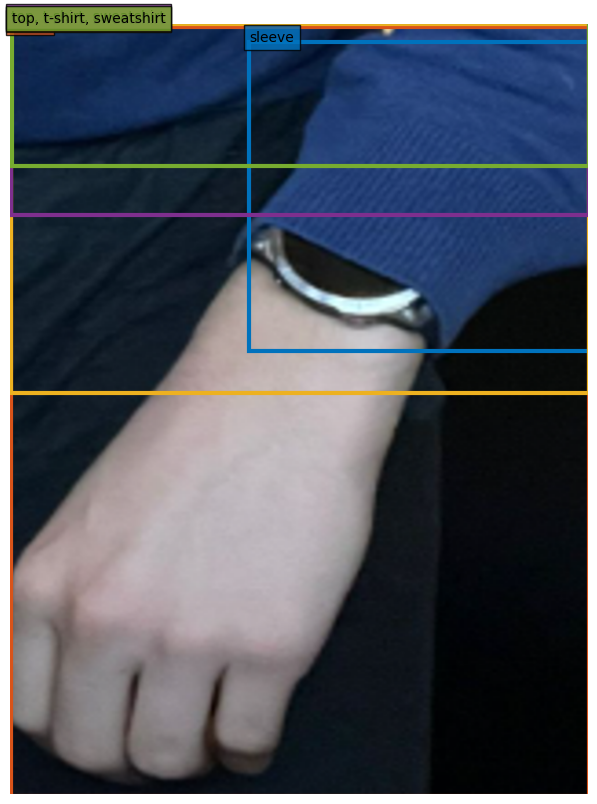

<Figure size 640x480 with 0 Axes>

In [11]:
MODEL_NAME = "DatSplit/yolos-base-fashionpedia"
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-base')
IMAGE_PATH = "test6.png"
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)
image = Image.open(open(IMAGE_PATH, "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
img = visualize_predictions(image, outputs, threshold=0.4)
img


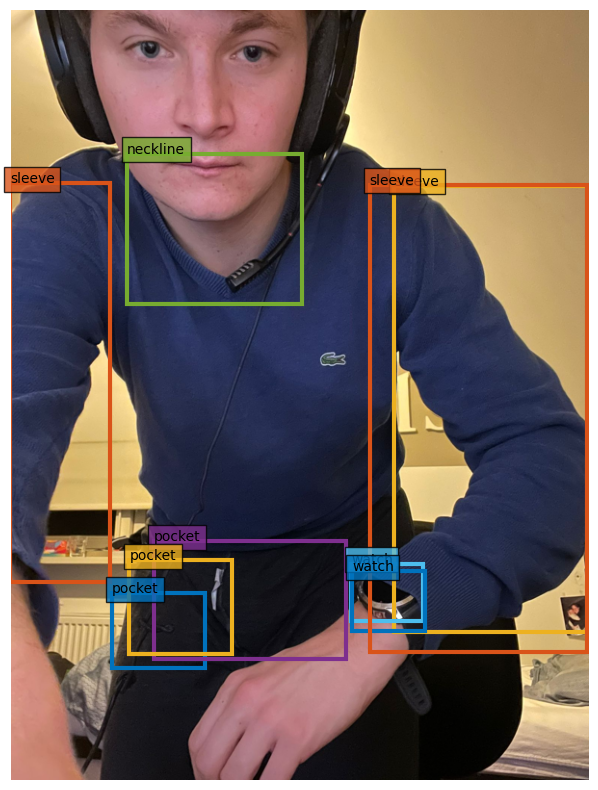

<Figure size 640x480 with 0 Axes>

In [ ]:
image = Image.open(open("test3.jpg", "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
img = visualize_predictions(image, outputs, threshold=0.5)
img

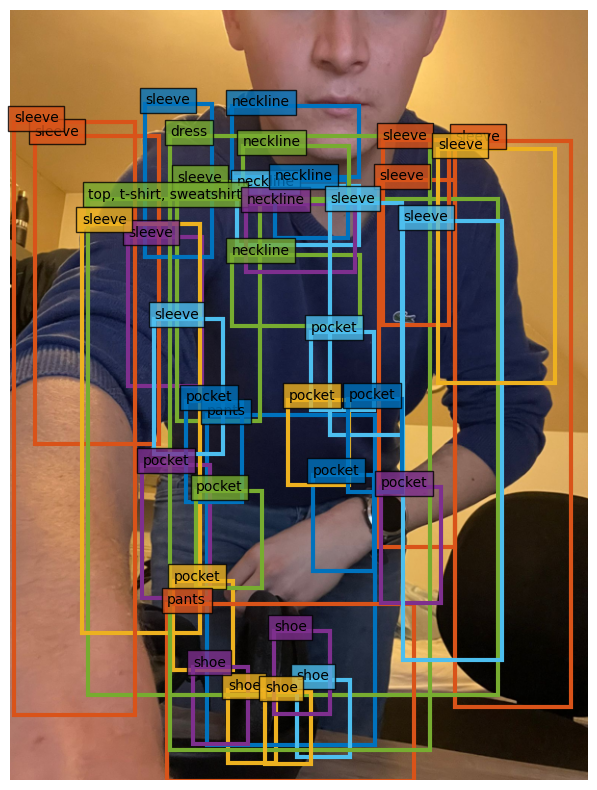

<Figure size 640x480 with 0 Axes>

In [ ]:
MODEL_NAME = "DatSplit/detr-resnet-101-fashionpedia"
feature_extractor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")
IMAGE_PATH = "test2.jpeg"
model = DetrForObjectDetection.from_pretrained(MODEL_NAME)
image = Image.open(open(IMAGE_PATH, "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
img = visualize_predictions(image, outputs, threshold=0.2)
img


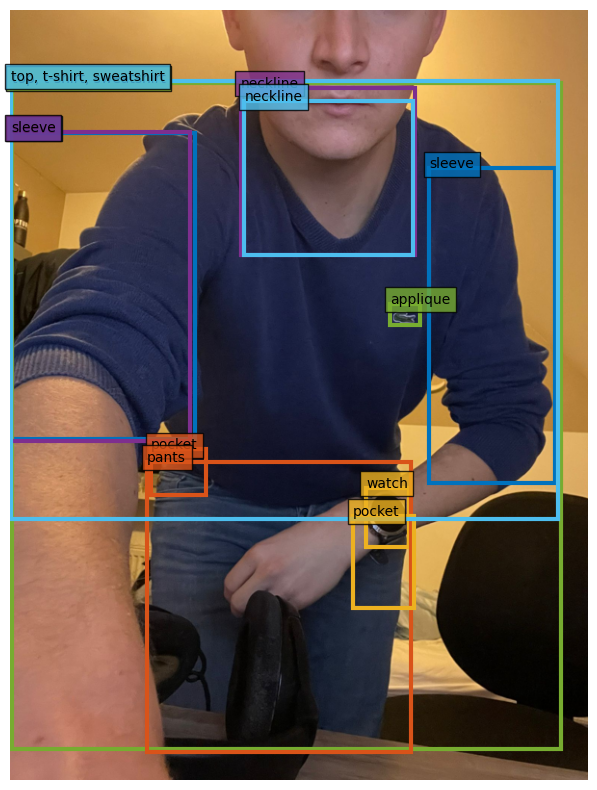

<Figure size 640x480 with 0 Axes>

In [ ]:
MODEL_NAME = "valentinafeve/yolos-fashionpedia"
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)
image = Image.open(open(IMAGE_PATH, "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
img = visualize_predictions(image, outputs, threshold=0.4)
img